Well, hopefully I will be able to make this work. 

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

## define functions

In [46]:
def low_density(lamb,a,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a low density regime
    (e.g. initiation limiting)
    '''
    Jl = (a*(lamb[0]-a))/(lamb[0] + (I-1)*a)
    pl = 1/(2*I) + (Jl*(I-1))/(2*I*lamb) - np.sqrt((1/(2*I) + (Jl*(I-1))/(2*I*lamb))**2 - Jl/(I*lamb))
    return(pl) 

def high_density(lamb,B,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a high density regime
    (e.g. termination limiting)
    '''
    JR = (B*(lamb[-1]-B))/(lamb[-1] + (I-1)*B)
    pR = 1/(2*I) + (JR*(I-1))/(2*I*lamb) + np.sqrt((1/(2*I) + (JR*(I-1))/(2*I*lamb))**2 - JR/(I*lamb))
    return(pR) 

def maximum_current(lamb,a,B,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a maximum current regime
    (e.g. elongation limiting)
    '''
    Jmax = min(lamb)/((1+np.sqrt(I))**2)
    flip = np.where(lamb == np.amin(lamb))[0][0]
    pR = 1/(2*I) + (Jmax*(I-1))/(2*I*lamb[0:flip]) + np.sqrt((1/(2*I) + (Jmax*(I-1))/(
        2*I*lamb[0:flip]))**2 - Jmax/(I*lamb[0:flip]))
    pl = 1/(2*I) + (Jmax*(I-1))/(2*I*lamb[flip:]) - np.sqrt((1/(2*I) + (Jmax*(I-1))/(
        2*I*lamb[flip:]))**2 - Jmax/(I*lamb[flip:]))
    p = np.concatenate((pR,pl))
    return(p) 

def lower_elon(arr_c, position, a, B, I = 10):
    '''
    This function purposefully induces elongation limitation at a certain point 
    '''
    lam_c = copy.deepcopy(arr_c)
    Jmax = min(lam_c)/((1+np.sqrt(I))**2)
    crit_a = ((lam_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lam_c[0]*Jmax)/((lam_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lam_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lam_c[-1]*Jmax)/((lam_c[-1] - (I - 1)*Jmax)**2)))
    mut_min = position
    while True:
        lam_c[mut_min] = lam_c[mut_min]*0.9 # It keeps doing this every run through. 
        Jmax = min(lam_c)/((1+np.sqrt(I))**2)
        crit_a = ((lam_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lam_c[0]*Jmax)/((lam_c[0] - (I - 1)*Jmax)**2)))
        crit_B = ((lam_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lam_c[-1]*Jmax)/((lam_c[-1] - (I - 1)*Jmax)**2)))
        if crit_a < a and crit_B < B:
            break
    p = maximum_current(lam_c,a=a,B=B,I = 10)
    return p

# I would like to create a function that determines which density function to use, 
# outputs a message saying which one it used, and then calculates the density with the correct function. 

def get_density(lamb, a, B, I = 10):
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    if a < crit_a and B > crit_B:
        p = low_density(lamb_c, a, I)
        print("Low Density Chosen")
    elif a > crit_a and B < crit_B:
        p = high_density(lamb_c, B, I)
        print("High Density Chosen")
    elif a < crit_a and B < crit_B:
        Jl = (a*(lamb[0]-a))/(lamb[0] + (I-1)*a)
        JR = (B*(lamb[-1]-B))/(lamb[-1] + (I-1)*B)
        sign = Jl - JR 
        if sign > 0:
            p = low_density(lamb_c, a, I)
            print("Low Density Chosen")
        elif sign < 0:
            p = high_density(lamb_c, B, I)
            print("High Density Chosen")
    elif a > crit_a and B > crit_B:
        p = maximum_current(lamb_c, a, B, I)
        print("Maximum Current Chosen")
    return p

What on earth am I drawing these samples from? I will use my gamma distribution but I should also just try a uniform ditribution like he told me too. 

In [218]:
lamb_gam = np.random.gamma(2.5,3,200)

In [219]:
p_gam = get_density(lamb_gam, 0.03, 0.1)

Maximum Current Chosen


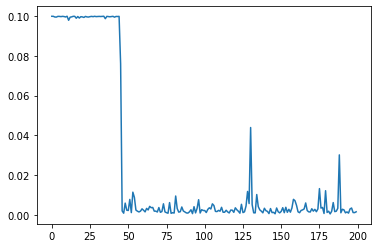

In [220]:
plt.plot(p_gam)

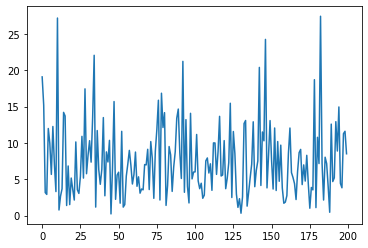

In [221]:
plt.plot(lamb_gam)

## Uniform distribution

In [211]:
lamb_uni = np.random.uniform(0.01,12, 200)

In [212]:
p_uni = get_density(lamb_uni, 0.01, 0.1)

Maximum Current Chosen


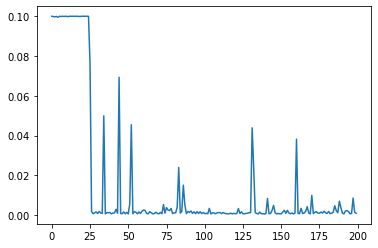

In [213]:
plt.plot(p_uni)

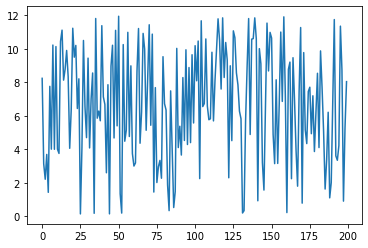

In [214]:
plt.plot(lamb_uni)

## Draw random samples from your particle densities

In [222]:
prob_gam = p_gam/sum(p_gam)

In [223]:
numpy.random.choice(np.arange(0, len(prob_gam)), p = prob_gam)

18

In [224]:
x = np.zeros(5)
x[4] = x[4]+1
x

array([0., 0., 0., 0., 1.])

In [233]:
empty = np.zeros(200)
for i in range(200):
    x = numpy.random.choice(np.arange(0, len(prob_gam)), p = prob_gam)
    empty[x] = empty[x]+1

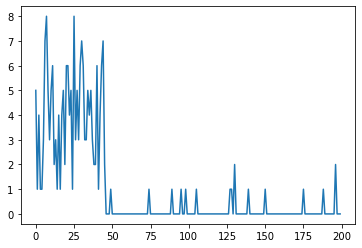

In [234]:
plt.plot(empty)

## Notes

What am I going to do for the power analysis? Should I just do the test on two simulated datasets (one that is elongation limited and one that is not) or perhaps I should do it on the two datasets combined together. 

ooohh ooohh, I know! I should set it up so that whenever elongation limitation does occur it gives it the mc tag and whenever it is low density it gets the ld tag. That way, I can run it without having to worry about the fact that elongation limitation might just occur in the LD group due to a very low rate being chosen for one of the random elongation rates. 